# Percettrone

## Dataset

Generiamo un dataset giocattolo per sperimentare con un classificatore percettrone

In [2]:
import pandas as pd
import numpy as np


def generate_dataset(n, dim, threshold=0.75):
    # Generate n points in dim-dimensional space // Matrix of random numbers
    points = np.random.rand(n, dim)

    # Create a DataFrame from the matrix of points
    df = pd.DataFrame(points)

    # Assign column names [x0..xDim]
    df.columns = ['x{}'.format(i) for i in range(dim)]

	# Set the target column depending on the sum of all the values in a certain row
    # - If the sum of all the attributes is below the threshold (0.75) then 0 otherwise 1
    df["label"] = np.where(df.sum(axis="columns") < threshold, 0, 1)

    return df

In [3]:
# Generate the dataframe using the function above
df = generate_dataset(1000, 2, 0.75)

In [4]:
# Print dataframe row to check the values / target label is correct
print(df.loc[[3]])

         x0       x1  label
3  0.967922  0.47336      1


## Dataset exploration

In [5]:
df.head(30)

,x0,x1,label
0,0.863907,0.278632,1
1,0.103702,0.756166,1
2,0.596588,0.918983,1
3,0.967922,0.473360,1
4,0.724491,0.486420,1
5,0.102260,0.649489,1
6,0.037590,0.320135,0
7,0.429682,0.221172,0
8,0.155064,0.319801,0
9,0.311255,0.248398,0


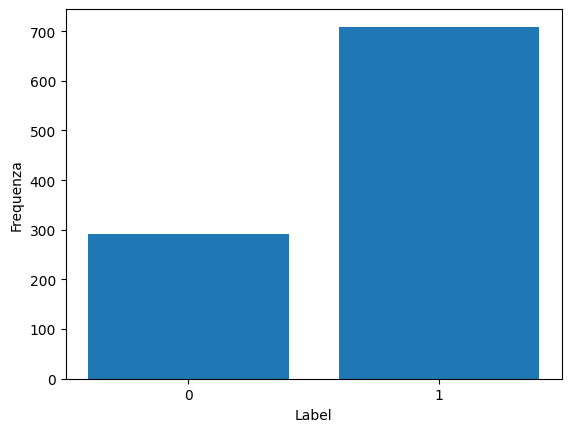

In [6]:
import matplotlib.pyplot as plt

# Unique label values on the X axis, Value counts on the Y axis
plt.bar(df["label"].unique(), df["label"].value_counts())
plt.ylabel("Frequenza")
plt.xlabel("Label")
plt.xticks([0, 1])
plt.show()

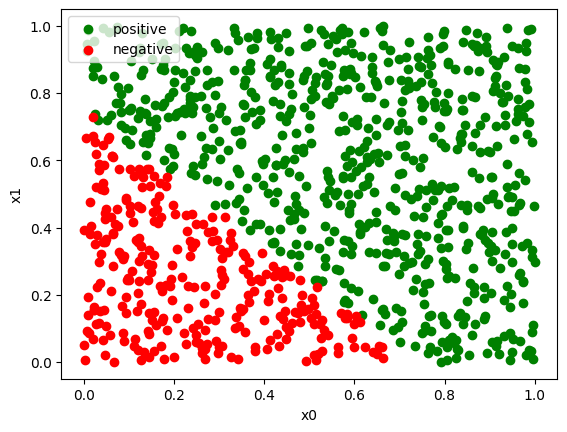

In [7]:
# dividiamo il DataFrame in due sotto-DataFrame in base alla label
df_pos = df[df['label'] == 1]
df_neg = df[df['label'] == 0]

# plot degli scatter plot per i due sotto-DataFrame
fig, ax = plt.subplots()
ax.scatter(df_pos['x0'], df_pos['x1'], c='green', label='positive')
ax.scatter(df_neg['x0'], df_neg['x1'], c='red', label='negative')

ax.legend()
ax.set_xlabel('x0')
ax.set_ylabel('x1')

plt.show()

In questo laboratorio dovrai **implementare il percettrone (tradizionale)** e il **percettrone (delta rule)**, seguendo questo pseudocodice:
<br><br>

**def** funzione(data, threshold) {

1. Initialize the weights: w0=-threshold, w1,w2 random

2. Set a control variable for convergence

3. Check convergency: all instances should be correctly classified.

   3. a. Adjust weights for misclassified instances

4. return weights

}

In [19]:
from pandas import DataFrame

def perceptron(data: DataFrame, threshold: float):
    input = data[['x0', 'x1']]
    target = data['label'].to_numpy()

    # Learning rate
    rate = 0.2

    # initialize bias weight
    w0 = -threshold

    # initialize weights
    w = np.random.rand(input.columns.size)

    # Control Variables
    converged = False
    tcount = 0

    while (not converged and tcount < 4000):
        converged = True
        for instance in range(len(input.index)):
            sum = w0

            # compute perceptron output
            for i in range(input.ndim):
                sum += input.values[instance][i] * w[i]

            perc_out = 0 if sum < 0 else 1


            #if actual output is different from expected output -> update weights with the perceptron rule
            if (target[instance] != perc_out):
                converged = False
                #print("w: {}".format(w))
                w0 = w0 + rate*(target[instance]-perc_out)*1
                for i in range(input.ndim):
                    #print("comp: targets {}-{}, input:{}".format(perc_out, target[instance], input.values[instance][i]))
                    w[i] = w[i] + rate*(target[instance]-perc_out)*input.values[instance][i]
        tcount += 1

    if (converged):
        print("CONVERGED!")
    elif (tcount >= 4000):
        print("FUCKING DEAD")

    return [w0, *w]

perceptron(df, 0.75)

CONVERGED!


[np.float64(-2.15),
 np.float64(2.8892922787291124),
 np.float64(2.8594644545209764)]

In [21]:
from pandas import DataFrame
from numpy import gradient

# get the gradient based on the Min Squared Error cost function
def gradient_of(target, x, w0, w):
    common = (target - w0 + w[0]*x[0] + w[1]*x[1])
    return [
        common * (-1),
        common * (x[0]),
        common * (x[1])
    ]

def compute_loss_function(target, x, w0, w):
    # Compute perceptron output
    perc_out = w0
    for i in range(len(x)):
        perc_out += w[i] + x[i]

    # Mean Squared Error (no need to sum cause output is in R^1)
    return 0.5*(target - perc_out)**2


def delta_perceptron(data: DataFrame, threshold: float):
    input = data[['x0', 'x1']]
    target = data['label'].to_numpy()

    # Learning rate
    rate = 0.001

    # initialize bias weight
    w0 = -threshold

    # initialize weights
    w = np.random.rand(input.columns.size)

    converged = False
    tcount = 0

    while (not converged and tcount < 1000):
        
        for instance in range(len(input.index)):
            gradient = gradient_of(target[instance], input.values[instance], w0, w)

            # Update weights
            w0 = w0 - rate * gradient[0]
            for i in range(input.ndim):
                w[i] = w[i] - rate * gradient[i+1]

        tcount += 1

        mse = compute_loss_function(target[0], input.values[0], w0, w)
        print(mse)

        if (mse < 0.001):
            converged = True
    
    if (tcount >= 1000):
        print("Fucking Dead")
    elif (converged):
        print("Converged!")

            
            

delta_perceptron(df, 0.75)

0.19991799042649763
0.12144821604862605
0.06870959692600827
0.033130994574382774
0.011379141564385619
0.001265326963711289
0.000997016767260655
Converged!
